_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 129, 313, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 129, 313, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 129, 313, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 127, 311, 64)      36928     
_________________________________________________________________
activation_2 (Activation)    (None, 127, 311, 64)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 127, 311, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 155, 64)       0         
__________

<Figure size 432x288 with 0 Axes>

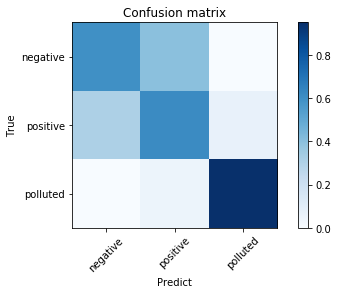

In [84]:
# coding: utf-8

import tensorflow as tf
import os
import random
import math
import time

import keras
import keras.backend as K
from keras import utils as np_utils
from keras import Sequential
from keras.models import load_model
from keras.utils import multi_gpu_model
from keras.layers import Activation,Dense,Dropout,MaxPooling2D,Flatten,Conv2D,GlobalMaxPooling2D,GlobalAveragePooling2D
from keras.optimizers import rmsprop,adam,SGD,Adadelta
import keras.losses
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard
from keras.preprocessing.image import ImageDataGenerator
import keras.backend.tensorflow_backend as KTF

import numpy as np
from PIL import Image
import cv2
import platform

from src.evaluate_tools import cam,plot_confusion_matrix
#train : python3 scriptname train
#predict: python3 scriptname predict [modelname]
#saliencymap: python3 scriptname cam [modelname] [dataset] [portion] [amount] [save/show]

positive_weigt=15.
polluted_weight=4.5
negative_weight=1.4
# if 'balance' in os.sys.argv:
#     positive_weigt=1
#     polluted_weight=1
#     negative_weight=1
height=131
width=315#420 #2.1
epoch=150#200 #1
vali_split=0.3

host = platform.node()  #cilegann-PC / ican-1080ti
mode = os.sys.argv[1] #train / predict / saliencymap
gpu='single'

model_to_load=''
if(mode=='predict' or mode=='cam'):
    model_to_load=os.sys.argv[2]
if(host=='ican-1080ti'):
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    session = tf.Session(config=config)
    KTF.set_session(session)
    batch_size=64
    if('balance' in os.sys.argv):
        batch_size=63
elif(host=='cilegann-PC'):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    session = tf.Session(config=config)
    KTF.set_session(session)
    batch_size=32
    if('balance' in os.sys.argv):
        batch_size=30

train_mapping_file='./data/CNN_x_y_mapping.csv'
vali_mapping_file='./data/CNN_vali_x_y_mapping.csv'

polluted_train_basedir='./data/polluted'
positive_train_basedir='./data/positive'
negative_train_basedir='./data/negative'
polluted_vali_basedir='./data/vali/polluted'
positive_vali_basedir='./data/vali/positive'
negative_vali_basedir='./data/vali/negative'

index = 0
vali_index = 0

train_x_file_list = []
train_x = []
train_y = []
train_start_index=[-1,-1,-1]
train_end_index=[-1,-1,-1]
train_len=[-1,-1,-1]

vali_x_file_list = []
vali_x=[]
vali_y = []
prob_y=[]
vali_start_index=[-1,-1,-1]
vali_end_index=[-1,-1,-1]
vali_len=[-1,-1,-1]

###################################################################################

def create_x_y_mapping(train_or_vali):
    basedir_list=[]
    if(train_or_vali=='train'):
        mapping_file=train_mapping_file
        basedir_list=[negative_train_basedir,positive_train_basedir,polluted_train_basedir]
    else:
        mapping_file=vali_mapping_file
        basedir_list=[negative_vali_basedir,positive_vali_basedir,polluted_vali_basedir]
    with open(mapping_file,'w') as f:
        f.write("file_path,label\n")
        for i,b in enumerate(basedir_list):
            for root, directs,filenames in os.walk(b):
                for filename in filenames:
                    if 'txt' not in filename:
                        pathName=os.path.join(root,filename)
                        if( ('jpg' in pathName) or ('png' in pathName) ):
                            f.write(pathName+','+str(i)+'\n')

###################################################################################

def read_x_y_mapping(train_or_vali,shuffle):
    if(train_or_vali=='train'):
        global train_x_file_list
        global train_y
        global train_start_index
        global train_end_index
        global train_len
        file_list=[]
        y=[]
        mapping_file=train_mapping_file
    else:
        global vali_x_file_list
        global vali_y
        global vali_start_index
        global vali_end_index
        global vali_len
        file_list=[]
        y=[]
        mapping_file=vali_mapping_file
    if(not os.path.exists(mapping_file)):
        create_x_y_mapping(train_or_vali)
    with open(mapping_file,'r') as f:
        next(f)
        lines=f.readlines()
        for line in lines:
            file_list.append(line.split(',')[0])
            y.append(line.split(',')[1][:-1])
    if(shuffle):
        c=list(zip(file_list,y))
        random.shuffle(c)
        file_list,y=zip(*c)
    else:
        s0=y.index('0')
        s1=y.index('1')
        s2=y.index('2')
        e0=s1-1
        e1=s2-1
        e2=len(y)-1
        l0=e0-s0+1
        l1=e1-s1+1
        l2=e2-s2+1
    if(train_or_vali=='train'):
        train_x_file_list=file_list
        train_y=np_utils.to_categorical(np.array(y),3)
        if not shuffle:
            train_start_index=[s0,s1,s2]
            train_end_index=[e0,e1,e2]
            train_len=[l0,l1,l2]
    else:
        vali_x_file_list=file_list
        vali_y=np_utils.to_categorical(np.array(y),3)
        if not shuffle:
            vali_start_index=[s0,s1,s2]
            vali_end_index=[e0,e1,e2]
            vali_len=[l0,l1,l2]

###################################################################################

def load_all_valid():
    global vali_x
    vali_x = np.zeros([len(vali_x_file_list), height, width, 3])
    for i,f in enumerate(vali_x_file_list):
        vali_x[i]=Image.open(f).resize([width,height])
    vali_x=vali_x.astype('float64')
    vali_x/=255.

###################################################################################

def generate_valid_from_train():
    global train_x_file_list
    global train_y
    global vali_x_file_list
    global vali_y
    vali_x_file_list = train_x_file_list[ :math.ceil(len(train_x_file_list)*vali_split) ]
    vali_y = train_y [ :math.ceil(len(train_x_file_list)*vali_split) ]
    train_x_file_list = train_x_file_list [math.floor(len(train_x_file_list)*vali_split):]
    train_y = train_y [math.floor(len(train_x_file_list)*vali_split):]

###################################################################################

def resize_preprocessing(data,label):
    data=data.resize([width,height])
    data = np.asarray(data)
    data = data.astype('float64')
    if (random.random() > 0.5 and int(label[1])==1):
        data = cv2.flip(data, 1)
    data/=255.
    return data

###################################################################################

def data_generator(is_training):
    global index
    global vali_index
    while(1):
        if is_training == True:
            if index + batch_size > len(train_x_file_list):
                index = 0
            file_list = train_x_file_list[index:index + batch_size]
            label_list = train_y[index:index + batch_size]
            index += batch_size
        else:
            if vali_index + batch_size > len(vali_x_file_list):
                vali_index = 0
            file_list = vali_x_file_list[vali_index:vali_index + batch_size]
            label_list = vali_y[vali_index:vali_index + batch_size]
            vali_index += batch_size

        output = np.zeros([batch_size, height,width, 3])
        for i in range(batch_size):
            output[i]=resize_preprocessing(Image.open(file_list[i]),label_list[i])

        yield output, label_list


###################################################################################

def data_generator_balance(is_training):
    if is_training:
        s=train_start_index[:]
        e=train_end_index[:]
        l=train_len[:]
    else:
        s=vali_start_index[:]
        e=vali_end_index[:]
        l=vali_len[:]
    flag=[0,0,0]
    while(1):
        file_list=[]
        label_list=[]
        for b in range(int(batch_size/3)):
            for i in range(3):
                index=flag[i]+s[i]
                if is_training:
                    file_list.append(train_x_file_list[index])
                    label_list.append(train_y[index])
                else:
                    file_list.append(vali_x_file_list[index])
                    label_list.append(vali_y[index])
                flag[i]+=1
                if(flag[i]>=l[i]):
                    flag[i]=0

        # c=list(zip(file_list,label_list))
        # random.shuffle(c)
        # file_list,label_list=zip(*c)
        label_list=np.asarray(label_list)
        output = np.zeros([batch_size, height,width, 3])
        for i in range(batch_size):
            output[i]=resize_preprocessing(Image.open(file_list[i]),label_list[i])
        yield(output,label_list)

###################################################################################

def get_model():
    model = Sequential()

    model.add(Conv2D(64,(3,3),strides=(1,1),input_shape=(height,width,3),data_format='channels_last'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),strides=(1,1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(128,(3,3),strides=(1,1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),strides=(1,1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(256,(3,3),strides=(1,1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3),strides=(1,1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3),strides=(1,1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))

    # model.add(Conv2D(1024,(3,3),strides=(1,1)))
    # model.add(Activation('relu'))
    # model.add(BatchNormalization())
    # model.add(Conv2D(1024,(3,3),strides=(1,1)))
    # model.add(Activation('relu'))
    # model.add(BatchNormalization())
    # model.add(Conv2D(1024,(3,3),strides=(1,1)))
    # model.add(Activation('relu'))
    # model.add(BatchNormalization())
    # model.add(MaxPooling2D(2,2))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Dense(3))
    model.add(Activation('softmax'))

    model.summary()
    return model

###################################################################################

def training(model):
    es=EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    #rlr=ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
    mck=ModelCheckpoint(filepath='cnn_model_best.h5',monitor='val_loss',save_best_only=True)
    tb = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

    if(host=='ican-1080ti' and gpu == 'both'):
        model = multi_gpu_model(model, gpus=2)
    class_weight = {0: negative_weight,1: positive_weigt,2: polluted_weight}
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    adadelta=Adadelta()
    model.compile(loss='categorical_crossentropy',optimizer=adadelta,metrics=['acc'])
    model.fit_generator(data_generator(True) if 'balance' not in os.sys.argv else data_generator_balance(True),validation_data=(vali_x,vali_y),validation_steps=1,steps_per_epoch=len(train_x_file_list)//batch_size, epochs=epoch,callbacks=[mck,es,tb],class_weight=class_weight)
    model.save('cnn_model.h5')

###################################################################################

def predict():
    global vali_x
    global model_to_load
    global prob_y
    global model_to_load
    if(model_to_load==''):
        model_to_load='cnn_model_best.h5'
    model=load_model(model_to_load)
    model.summary()
    read_x_y_mapping('vali',False)
    load_all_valid()
    loss, accuracy = model.evaluate(vali_x, vali_y)
    print("loss: "+str(loss))
    print("accu: "+str(accuracy))
    prob_y = model.predict(vali_x)
    y_true=[]
    y_pred=[]
    with open('result.csv','w') as file:
        file.write("filename,real_value,pred_value\n")
        for i,p in enumerate(vali_x_file_list):
            file.write(p+","+str(np.argmax(vali_y[i]))+","+str(np.argmax(prob_y[i]))+'\n')
            print(str(i)+" "+ str(np.argmax(vali_y[i])) +" -> "+str(np.argmax(prob_y[i])))
    y_true=np.argmax(vali_y,axis=1)
    y_pred=np.argmax(prob_y,axis=1)
    labels=["negative", "positive", "polluted"]
    plot_confusion_matrix(y_true,y_pred,classes=labels)
        
    return y_true,y_pred

        
###################################################################################

def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

def cam(filename,img,label,model,backprop_modifier='guided'):
    shutil.rmtree("./cam/")
    os.mkdir("cam")
    np.seterr(divide='ignore',invalid='ignore')
    
    filename='./cam/'+filename+'.jpg'
    print(filename)
    heatmap = visualize_cam(model, layer_idx=-1, filter_indices=label, seed_input=img,backprop_modifier=backprop_modifier)
    jet_heatmap = np.uint8(cm.jet(heatmap)[..., :3] * 255)

    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.subplot(1,2,2)
    im1=plt.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
    im2 = plt.imshow(heatmap,  alpha=.4, interpolation='bilinear')
    plt.savefig(filename,dpi=300)


def main():
    model=load_model('./cnn_model_best.h5')
    imgs=[]
    y_true,y_pred=predict()
    for i,img in enumerate(imgs):
        cam(str(i)+'_'+y_pred[i],img,y_pred[i],model)

if __name__ == "__main__":
    main()

